<a href="https://colab.research.google.com/github/alim98/MPI/blob/main/Helper_Functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O downloaded_file.zip "https://drive.usercontent.google.com/download?id=1iHPBdBOPEagvPTHZmrN__LD49emXwReY&export=download&authuser=0&confirm=t&uuid=631d60dd-569c-4bb1-a9e8-d681f0ed3d43&at=APvzH3r4me8x_LwP3n8O7lgPo8oK%3A1733988188000"

# !pip -q install transformers scikit-learn matplotlib seaborn torch torchvision umap-learn openpyxl imageio

!unzip -q downloaded_file.zip


--2025-01-15 07:33:22--  https://drive.usercontent.google.com/download?id=1iHPBdBOPEagvPTHZmrN__LD49emXwReY&export=download&authuser=0&confirm=t&uuid=631d60dd-569c-4bb1-a9e8-d681f0ed3d43&at=APvzH3r4me8x_LwP3n8O7lgPo8oK%3A1733988188000
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.134.132, 2607:f8b0:400c:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.134.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1264688649 (1.2G) [application/octet-stream]
Saving to: ‘downloaded_file.zip’

downloaded_file.zip 100%[===================>]   1.18G  45.4MB/s    in 22s     

2025-01-15 07:33:45 (55.4 MB/s) - ‘downloaded_file.zip’ saved [1264688649/1264688649]



In [ ]:
# prompt: import Dataset

!wget -O downloaded_file.zip "https://drive.usercontent.google.com/download?id=1iHPBdBOPEagvPTHZmrN__LD49emXwReY&export=download&authuser=0&confirm=t&uuid=631d60dd-569c-4bb1-a9e8-d681f0ed3d43&at=APvzH3r4me8x_LwP3n8O7lgPo8oK%3A1733988188000"

# !pip -q install transformers scikit-learn matplotlib seaborn torch torchvision umap-learn openpyxl imageio

!unzip -q downloaded_file.zip

In [ ]:

import os
import glob
import numpy as np
import imageio.v2 as imageio
import pandas as pd
import matplotlib.pyplot as pltimport numpy as np
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from skimage import io as iio
from sklearn.model_selection import train_test_split

def load_volumes(bbox_name, raw_base_dir, seg_base_dir):
    """
    Load raw volume and segmentation volume for a bounding box.
    """
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

    if len(raw_tif_files) == 0 or len(seg_tif_files) == 0:
        print(f"No raw or segmentation files found for {bbox_name}")
        return None, None

    raw_vol = np.stack([iio.imread(f) for f in raw_tif_files], axis=0)
    seg_vol = np.stack([iio.imread(f).astype(np.uint32) for f in seg_tif_files], axis=0)

    return raw_vol, seg_vol

class VideoMAEDataset(Dataset):
    """
    Dataset class that uses segmented volumes (side1 & side2) for VideoMAE pre-training.
    """
    def __init__(self, vol_data_list, synapse_df, subvol_size=80, num_frames=80):
        """
        Args:
            vol_data_list (List[Tuple[np.ndarray, np.ndarray]]): List of (raw_vol, seg_vol).
            synapse_df (pd.DataFrame): DataFrame with synapse coordinates (central, side1, side2).
            subvol_size (int): Spatial size of the sub-volume to extract.
            num_frames (int): Number of frames for the model.
        """
        self.vol_data_list = vol_data_list
        self.synapse_df = synapse_df
        self.subvol_size = subvol_size
        self.num_frames = num_frames

    def __len__(self):
        return len(self.synapse_df)

    def __getitem__(self, idx):
        syn_info = self.synapse_df.iloc[idx]
        bbox_index = syn_info['bbox_index']

        raw_vol, seg_vol = self.vol_data_list[bbox_index]
        if raw_vol is None or seg_vol is None:
            # Return dummy data if volumes not found
            pixel_values = torch.zeros((3, self.subvol_size, self.subvol_size, self.subvol_size), dtype=torch.float32)
            return pixel_values

        # Coordinates
        central_coord = (
            int(syn_info['central_coord_1']),
            int(syn_info['central_coord_2']),
            int(syn_info['central_coord_3'])
        )
        side1_coord = (
            int(syn_info['side_1_coord_1']),
            int(syn_info['side_1_coord_2']),
            int(syn_info['side_1_coord_3'])
        )
        side2_coord = (
            int(syn_info['side_2_coord_1']),
            int(syn_info['side_2_coord_2']),
            int(syn_info['side_2_coord_3'])
        )

        # Calculate the cropping bounds for spatial (Y, X) and temporal (Z)
        half_size = self.subvol_size // 2
        cx, cy, cz = central_coord

        # X and Y bounding box (80x80)
        x_start, x_end = max(cx - half_size, 0), min(cx + half_size, raw_vol.shape[2])
        y_start, y_end = max(cy - half_size, 0), min(cy + half_size, raw_vol.shape[1])

        # Z bounding box (80 frames)
        z_start, z_end = max(cz - half_size, 0), min(cz + half_size, raw_vol.shape[0])

        # Extract subvolumes
        sub_raw = raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_mask_1 = (seg_vol[z_start:z_end, y_start:y_end, x_start:x_end] == seg_vol[side1_coord])
        sub_mask_2 = (seg_vol[z_start:z_end, y_start:y_end, x_start:x_end] == seg_vol[side2_coord])

        # Padding if necessary (in case the bounding box is close to the boundaries)
        if sub_raw.shape[1] < self.subvol_size or sub_raw.shape[2] < self.subvol_size:
            pad_x = self.subvol_size - sub_raw.shape[2]
            pad_y = self.subvol_size - sub_raw.shape[1]

            sub_raw = np.pad(sub_raw, ((0, 0), (0, pad_y), (0, pad_x)), mode='constant', constant_values=0)
            sub_mask_1 = np.pad(sub_mask_1, ((0, 0), (0, pad_y), (0, pad_x)), mode='constant', constant_values=False)
            sub_mask_2 = np.pad(sub_mask_2, ((0, 0), (0, pad_y), (0, pad_x)), mode='constant', constant_values=False)

        # Ensure the final shape is (80, 80, 80)
        assert sub_raw.shape == (self.num_frames, self.subvol_size, self.subvol_size), \
            f"Expected subvolume size: {(self.num_frames, self.subvol_size, self.subvol_size)}, but got: {sub_raw.shape}"

        # Stack the data into the three channels (presynapse, raw volume, postsynapse)
        channel_0 = sub_mask_1.astype(np.uint8)  # Presynapse in red channel
        channel_1 = sub_raw.astype(np.uint8)  # Raw volume in green channel
        channel_2 = sub_mask_2.astype(np.uint8)  # Postsynapse in blue channel

        # Stack into a 4D tensor: (3, 80, 80, 80)
        pixel_values = np.stack([channel_0, channel_1, channel_2], axis=0)

        return torch.tensor(pixel_values, dtype=torch.float32)

def generate_data_loader(vol_data_list, synapse_df, batch_size=4, subvol_size=80, num_frames=80):
    dataset = VideoMAEDataset(vol_data_list=vol_data_list, synapse_df=synapse_df, subvol_size=subvol_size, num_frames=num_frames)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Example usage

# Assuming `raw_vol` and `seg_vol` are already loaded for each bounding box.
# Assuming `synapse_df` contains the synapse coordinate data (central, side1, side2).
vol_data_list = [(raw_vol, seg_vol)]  # Replace with your actual data
synapse_df = pd.DataFrame({
    'bbox_index': [0],  # Replace with your actual bounding box indices
    'central_coord_1': [100], 'central_coord_2': [100], 'central_coord_3': [50],
    'side_1_coord_1': [90], 'side_1_coord_2': [90], 'side_1_coord_3': [50],
    'side_2_coord_1': [110], 'side_2_coord_2': [110], 'side_2_coord_3': [50]
})  # Replace with your actual synapse data

# Generate data loader
train_loader = generate_data_loader(vol_data_list, synapse_df)

# Get one batch
for batch in train_loader:
    print(batch.shape)  # Should print torch.Size([batch_size, 3, 80, 80, 80])
    break


def get_segmented_images(raw_base_dir, seg_base_dir, bbox_name, excel_file, var1, subvolume_size=80, alpha=0.3):
    """
    Extracts two 80x80 segmented 2D masks (Side 1 and Side 2) around the specified synapse
    using Var1 from the Excel file and overlays both segmentation masks on a single raw image
    with specified transparency.

    Parameters:
        raw_base_dir (str): Directory containing raw image slices.
        seg_base_dir (str): Directory containing segmentation image slices.
        bbox_name (str): Name of the bounding box to process.
        excel_file (str): Path to the Excel file containing synapse data.
        var1 (str): Var1 identifier of the synapse to process.
        subvolume_size (int): Size of the subvolume to extract around the central coordinate.
        alpha (float): Transparency level for the masks (0.0 transparent, 1.0 opaque).

    Returns:
        np.ndarray: RGB numpy array with both masks overlaid on the raw image.
    """
    # Load raw and segmentation volumes
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    raw_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

    if len(raw_files) == 0:
        raise FileNotFoundError(f"No raw .tif files found in directory: {raw_dir}")
    if len(seg_files) == 0:
        raise FileNotFoundError(f"No segmentation .tif files found in directory: {seg_dir}")
    if len(raw_files) != len(seg_files):
        raise ValueError("Number of raw and segmentation files do not match.")

    # Load volumes
    try:
        raw_vol = np.stack([imageio.imread(f) for f in raw_files], axis=0)
        seg_vol = np.stack([imageio.imread(f).astype(np.uint32) for f in seg_files], axis=0)
    except Exception as e:
        raise IOError(f"Error loading image files: {e}")

    # Load synapse data
    try:
        synapse_data = pd.read_excel(excel_file)
    except Exception as e:
        raise IOError(f"Error reading Excel file '{excel_file}': {e}")

    # Find the synapse row based on Var1
    synapse_row = synapse_data[synapse_data['Var1'] == var1]
    if synapse_row.empty:
        raise ValueError(f"No synapse found with Var1: '{var1}' in Excel file '{excel_file}'.")

    syn_info = synapse_row.iloc[0]

    # Extract coordinates
    try:
        central_coord = (
            int(syn_info['central_coord_1']),
            int(syn_info['central_coord_2']),
            int(syn_info['central_coord_3'])
        )
        side1_coord = (
            int(syn_info['side_1_coord_1']),
            int(syn_info['side_1_coord_2']),
            int(syn_info['side_1_coord_3'])
        )
        side2_coord = (
            int(syn_info['side_2_coord_1']),
            int(syn_info['side_2_coord_2']),
            int(syn_info['side_2_coord_3'])
        )
    except KeyError as e:
        raise KeyError(f"Missing column in Excel file: {e}")
    except ValueError as e:
        raise ValueError(f"Invalid coordinate value: {e}")

    # Create segmentation masks based on coordinates
    def create_segment_masks(seg_vol, side1_coord, side2_coord):
        x1, y1, z1 = side1_coord
        x2, y2, z2 = side2_coord

        # Validate coordinates
        if not (0 <= z1 < seg_vol.shape[0] and 0 <= y1 < seg_vol.shape[1] and 0 <= x1 < seg_vol.shape[2]):
            raise ValueError("Side1 coordinates are out of bounds.")
        if not (0 <= z2 < seg_vol.shape[0] and 0 <= y2 < seg_vol.shape[1] and 0 <= x2 < seg_vol.shape[2]):
            raise ValueError("Side2 coordinates are out of bounds.")

        seg_id_1 = seg_vol[z1, y1, x1]
        seg_id_2 = seg_vol[z2, y2, x2]

        if seg_id_1 == 0:
            mask_1 = np.zeros_like(seg_vol, dtype=bool)
        else:
            mask_1 = (seg_vol == seg_id_1)

        if seg_id_2 == 0:
            mask_2 = np.zeros_like(seg_vol, dtype=bool)
        else:
            mask_2 = (seg_vol == seg_id_2)

        return mask_1, mask_2

    try:
        mask_1_full, mask_2_full = create_segment_masks(seg_vol, side1_coord, side2_coord)
    except Exception as e:
        raise ValueError(f"Error creating segmentation masks: {e}")

    # Extract subvolume around central coordinate
    half_size = subvolume_size // 2
    cx, cy, cz = central_coord

    x_start, x_end = max(cx - half_size, 0), min(cx + half_size, raw_vol.shape[2])
    y_start, y_end = max(cy - half_size, 0), min(cy + half_size, raw_vol.shape[1])
    z_slice = cz  # Assuming a single central slice in Z-axis

    if z_slice < 0 or z_slice >= raw_vol.shape[0]:
        raise ValueError("Central Z-coordinate is out of bounds.")

    sub_raw = raw_vol[z_slice, y_start:y_end, x_start:x_end]
    sub_mask_1 = mask_1_full[z_slice, y_start:y_end, x_start:x_end]
    sub_mask_2 = mask_2_full[z_slice, y_start:y_end, x_start:x_end]

    # Ensure the extracted subvolume is exactly subvolume_size x subvolume_size
    if sub_raw.shape[0] != subvolume_size or sub_raw.shape[1] != subvolume_size:
        pad_y = subvolume_size - sub_raw.shape[0]
        pad_x = subvolume_size - sub_raw.shape[1]
        sub_raw = np.pad(sub_raw, ((0, pad_y), (0, pad_x)), mode='constant', constant_values=0)
        sub_mask_1 = np.pad(sub_mask_1, ((0, pad_y), (0, pad_x)), mode='constant', constant_values=False)
        sub_mask_2 = np.pad(sub_mask_2, ((0, pad_y), (0, pad_x)), mode='constant', constant_values=False)

    # Normalize raw image to [0, 1] for blending
    raw_normalized = sub_raw.astype(np.float32)
    raw_min, raw_max = raw_normalized.min(), raw_normalized.max()
    if raw_max != raw_min:
        raw_normalized = (raw_normalized - raw_min) / (raw_max - raw_min)
    else:
        raw_normalized = raw_normalized - raw_min  # All zeros

    raw_rgb = np.stack([raw_normalized]*3, axis=-1)  # Convert to RGB

    # Create colored masks
    side1_color = np.array([1, 0, 0])  # Red
    side2_color = np.array([0, 0, 1])  # Blue

    mask1_rgb = np.zeros_like(raw_rgb)
    mask1_rgb[sub_mask_1] = side1_color

    mask2_rgb = np.zeros_like(raw_rgb)
    mask2_rgb[sub_mask_2] = side2_color

    # Blend both masks with raw image
    overlaid_image = np.clip((1 - alpha) * raw_rgb + alpha * (mask1_rgb + mask2_rgb), 0, 1)

    # Ensure that overlapping masks don't exceed the alpha blending
    overlaid_image = np.clip(overlaid_image, 0, 1)

    # Convert back to uint8
    overlaid_image = (overlaid_image * 255).astype(np.uint8)

    return overlaid_image

def create_segmented_cube(raw_base_dir, seg_base_dir, bbox_name, excel_file, var1, subvolume_size=80, alpha=0.3):
    """
    Constructs an 80x80x80 segmented 3D cube around the specified synapse using Var1 from the Excel file
    and overlays both segmentation masks on the raw data with specified transparency for each slice.

    Parameters:
        raw_base_dir (str): Directory containing raw image slices.
        seg_base_dir (str): Directory containing segmentation image slices.
        bbox_name (str): Name of the bounding box to process.
        excel_file (str): Path to the Excel file containing synapse data.
        var1 (str): Var1 identifier of the synapse to process.
        subvolume_size (int): Size of the subvolume to extract around the central coordinate.
        alpha (float): Transparency level for the masks (0.0 transparent, 1.0 opaque).

    Returns:
        np.ndarray: RGB numpy array with both masks overlaid on each slice of the raw cube.
                   Shape: (height, width, channels, depth)
    """
    # Load raw and segmentation volumes
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    raw_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

    if len(raw_files) == 0:
        raise FileNotFoundError(f"No raw .tif files found in directory: {raw_dir}")
    if len(seg_files) == 0:
        raise FileNotFoundError(f"No segmentation .tif files found in directory: {seg_dir}")
    if len(raw_files) != len(seg_files):
        raise ValueError("Number of raw and segmentation files do not match.")

    # Load volumes
    try:
        raw_vol = np.stack([imageio.imread(f) for f in raw_files], axis=0)
        seg_vol = np.stack([imageio.imread(f).astype(np.uint32) for f in seg_files], axis=0)
    except Exception as e:
        raise IOError(f"Error loading image files: {e}")

    # Load synapse data
    try:
        synapse_data = pd.read_excel(excel_file)
    except Exception as e:
        raise IOError(f"Error reading Excel file '{excel_file}': {e}")

    # Find the synapse row based on Var1
    synapse_row = synapse_data[synapse_data['Var1'] == var1]
    if synapse_row.empty:
        raise ValueError(f"No synapse found with Var1: '{var1}' in Excel file '{excel_file}'.")

    syn_info = synapse_row.iloc[0]

    # Extract coordinates
    try:
        central_coord = (
            int(syn_info['central_coord_1']),
            int(syn_info['central_coord_2']),
            int(syn_info['central_coord_3'])
        )
        side1_coord = (
            int(syn_info['side_1_coord_1']),
            int(syn_info['side_1_coord_2']),
            int(syn_info['side_1_coord_3'])
        )
        side2_coord = (
            int(syn_info['side_2_coord_1']),
            int(syn_info['side_2_coord_2']),
            int(syn_info['side_2_coord_3'])
        )
    except KeyError as e:
        raise KeyError(f"Missing column in Excel file: {e}")
    except ValueError as e:
        raise ValueError(f"Invalid coordinate value: {e}")

    # Create segmentation masks based on coordinates
    def create_segment_masks(seg_vol, side1_coord, side2_coord):
        x1, y1, z1 = side1_coord
        x2, y2, z2 = side2_coord

        # Validate coordinates
        if not (0 <= z1 < seg_vol.shape[0] and 0 <= y1 < seg_vol.shape[1] and 0 <= x1 < seg_vol.shape[2]):
            raise ValueError("Side1 coordinates are out of bounds.")
        if not (0 <= z2 < seg_vol.shape[0] and 0 <= y2 < seg_vol.shape[1] and 0 <= x2 < seg_vol.shape[2]):
            raise ValueError("Side2 coordinates are out of bounds.")

        seg_id_1 = seg_vol[z1, y1, x1]
        seg_id_2 = seg_vol[z2, y2, x2]

        if seg_id_1 == 0:
            mask_1 = np.zeros_like(seg_vol, dtype=bool)
        else:
            mask_1 = (seg_vol == seg_id_1)

        if seg_id_2 == 0:
            mask_2 = np.zeros_like(seg_vol, dtype=bool)
        else:
            mask_2 = (seg_vol == seg_id_2)

        return mask_1, mask_2

    try:
        mask_1_full, mask_2_full = create_segment_masks(seg_vol, side1_coord, side2_coord)
    except Exception as e:
        raise ValueError(f"Error creating segmentation masks: {e}")

    # Define the range for the cube
    half_size = subvolume_size // 2
    cx, cy, cz = central_coord

    x_start, x_end = max(cx - half_size, 0), min(cx + half_size, raw_vol.shape[2])
    y_start, y_end = max(cy - half_size, 0), min(cy + half_size, raw_vol.shape[1])
    z_start, z_end = max(cz - half_size, 0), min(cz + half_size, raw_vol.shape[0])

    sub_raw = raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]
    sub_mask_1 = mask_1_full[z_start:z_end, y_start:y_end, x_start:x_end]
    sub_mask_2 = mask_2_full[z_start:z_end, y_start:y_end, x_start:x_end]

    # If the extracted subvolume is smaller than desired, pad it
    pad_z = subvolume_size - sub_raw.shape[0]
    pad_y = subvolume_size - sub_raw.shape[1]
    pad_x = subvolume_size - sub_raw.shape[2]

    if pad_z > 0 or pad_y > 0 or pad_x > 0:
        sub_raw = np.pad(sub_raw, ((0, pad_z), (0, pad_y), (0, pad_x)), mode='constant', constant_values=0)
        sub_mask_1 = np.pad(sub_mask_1, ((0, pad_z), (0, pad_y), (0, pad_x)), mode='constant', constant_values=False)
        sub_mask_2 = np.pad(sub_mask_2, ((0, pad_z), (0, pad_y), (0, pad_x)), mode='constant', constant_values=False)

    # Ensure the subvolume is exactly subvolume_size x subvolume_size x subvolume_size
    sub_raw = sub_raw[:subvolume_size, :subvolume_size, :subvolume_size]
    sub_mask_1 = sub_mask_1[:subvolume_size, :subvolume_size, :subvolume_size]
    sub_mask_2 = sub_mask_2[:subvolume_size, :subvolume_size, :subvolume_size]

    # Initialize cube for overlaid images
    overlaid_cube = np.zeros((subvolume_size, subvolume_size, 3, subvolume_size), dtype=np.uint8)

    # Define colors
    side1_color = np.array([1, 0, 0])  # Red
    side2_color = np.array([0, 0, 1])  # Blue

    # Process each slice
    for z in range(subvolume_size):
        # Normalize raw image to [0, 1] for blending
        raw_normalized = sub_raw[z].astype(np.float32)
        raw_min, raw_max = raw_normalized.min(), raw_normalized.max()
        if raw_max != raw_min:
            raw_normalized = (raw_normalized - raw_min) / (raw_max - raw_min)
        else:
            raw_normalized = raw_normalized - raw_min  # All zeros

        raw_rgb = np.stack([raw_normalized]*3, axis=-1)  # Convert to RGB

        # Create colored masks
        mask1_rgb = np.zeros_like(raw_rgb)
        mask1_rgb[sub_mask_1[z]] = side1_color

        mask2_rgb = np.zeros_like(raw_rgb)
        mask2_rgb[sub_mask_2[z]] = side2_color

        # Blend both masks with raw image
        overlaid_image = np.clip((1 - alpha) * raw_rgb + alpha * (mask1_rgb + mask2_rgb), 0, 1)

        # Ensure that overlapping masks don't exceed the alpha blending
        overlaid_image = np.clip(overlaid_image, 0, 1)

        # Convert back to uint8
        overlaid_image = (overlaid_image * 255).astype(np.uint8)

        # Assign to cube (axes: height, width, channels, depth)
        overlaid_cube[:, :, :, z] = overlaid_image

    return overlaid_cube

3D volumetric data
Channel 0: cropped side1 (Presynapse).
Channel 1: Full Raw.
Channel 2: cropped side2 (Postsynapse).

Total synapses loaded: 58
Batch 0 shape: torch.Size([2, 3, 80, 80, 80])


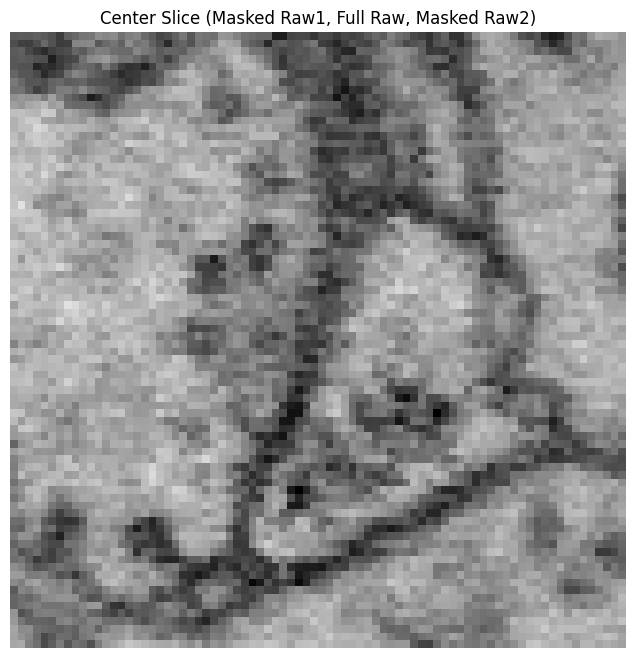

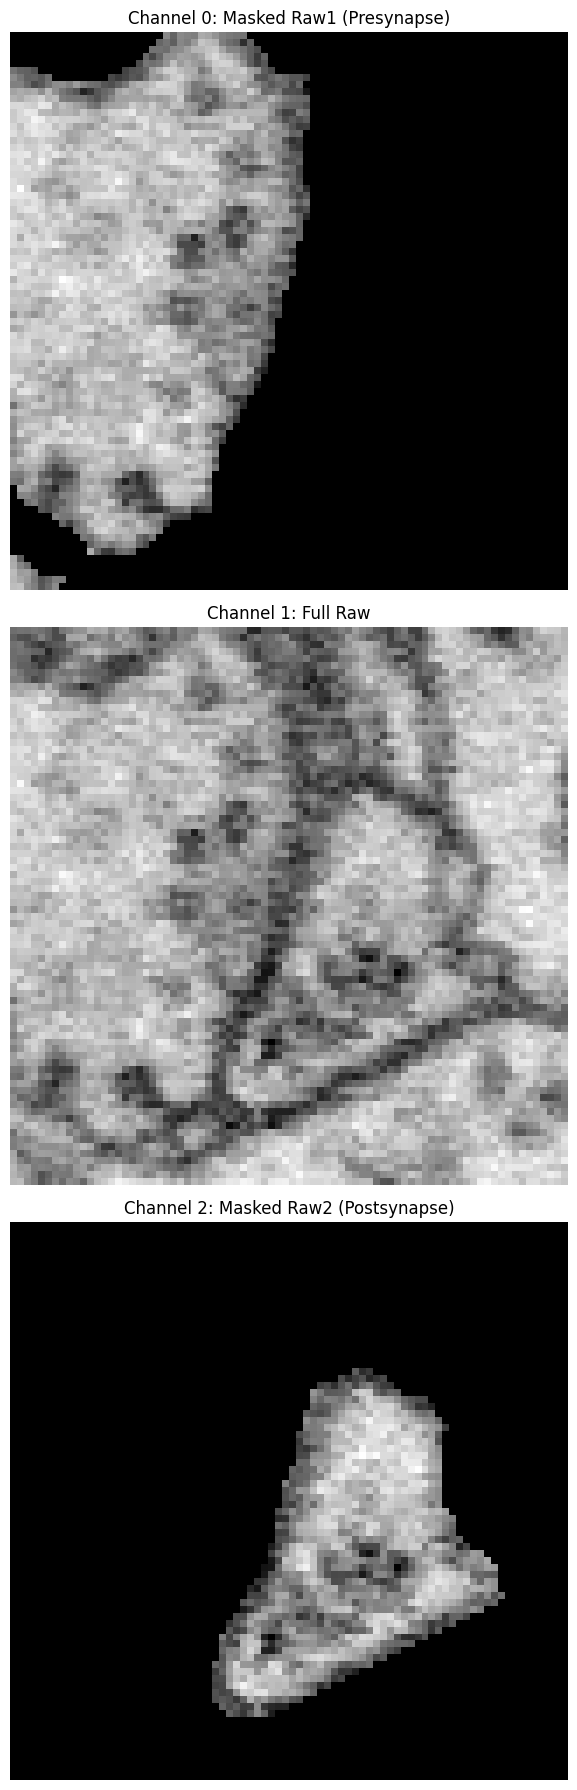

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import imageio.v2 as imageio  # Use imageio.v2 to avoid DeprecationWarnings
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def load_volumes(bbox_name, raw_base_dir, seg_base_dir):
    """
    Load raw volume and segmentation volume for a bounding box.

    Args:
        bbox_name (str): Name of the bounding box directory.
        raw_base_dir (str): Base directory for raw data.
        seg_base_dir (str): Base directory for segmentation data.

    Returns:
        tuple: (raw_vol, seg_vol) each as np.ndarray or (None, None) if loading fails.
    """
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

    if len(raw_tif_files) == 0:
        print(f"No raw files found for {bbox_name} in {raw_dir}")
        return None, None

    if len(seg_tif_files) == 0:
        print(f"No segmentation files found for {bbox_name} in {seg_dir}")
        return None, None

    if len(raw_tif_files) != len(seg_tif_files):
        print(f"Mismatch in number of raw vs seg slices for {bbox_name}. Skipping.")
        return None, None

    try:
        raw_vol = np.stack([imageio.imread(f) for f in raw_tif_files], axis=0)  # shape: (Z, Y, X)
        seg_vol = np.stack([imageio.imread(f).astype(np.uint32) for f in seg_tif_files], axis=0)
        return raw_vol, seg_vol
    except Exception as e:
        print(f"Error loading volumes for {bbox_name}: {e}")
        return None, None


def create_segmented_cube(
    raw_vol,
    seg_vol,
    central_coord,
    side1_coord,
    side2_coord,
    subvolume_size=80,
    alpha=0.3
):
    """
    Constructs an 80x80x80 segmented 3D cube around the specified synapse coordinates
    and overlays both segmentation masks (side1_coord, side2_coord) on the raw data
    with specified transparency for each slice.

    Returns:
        np.ndarray: Overlaid cube of shape (3, 80, 80, 80).
                    Channels: [Masked Raw1, Full Raw, Masked Raw2]
    """
    def create_segment_masks(segmentation_volume, s1_coord, s2_coord):
        x1, y1, z1 = s1_coord
        x2, y2, z2 = s2_coord
        # Validate within volume
        if not (0 <= z1 < segmentation_volume.shape[0] and
                0 <= y1 < segmentation_volume.shape[1] and
                0 <= x1 < segmentation_volume.shape[2]):
            raise ValueError("Side1 coordinates are out of bounds.")

        if not (0 <= z2 < segmentation_volume.shape[0] and
                0 <= y2 < segmentation_volume.shape[1] and
                0 <= x2 < segmentation_volume.shape[2]):
            raise ValueError("Side2 coordinates are out of bounds.")

        seg_id_1 = segmentation_volume[z1, y1, x1]
        seg_id_2 = segmentation_volume[z2, y2, x2]

        # If seg_id == 0, it means no segment at that voxel
        if seg_id_1 == 0:
            mask_1 = np.zeros_like(segmentation_volume, dtype=bool)
        else:
            mask_1 = (segmentation_volume == seg_id_1)

        if seg_id_2 == 0:
            mask_2 = np.zeros_like(segmentation_volume, dtype=bool)
        else:
            mask_2 = (segmentation_volume == seg_id_2)

        return mask_1, mask_2

    # Build masks
    mask_1_full, mask_2_full = create_segment_masks(seg_vol, side1_coord, side2_coord)

    # Define subvolume bounds
    half_size = subvolume_size // 2
    cx, cy, cz = central_coord

    # X and Y bounding box (80x80)
    x_start, x_end = max(cx - half_size, 0), min(cx + half_size, raw_vol.shape[2])
    y_start, y_end = max(cy - half_size, 0), min(cy + half_size, raw_vol.shape[1])

    # Z bounding box (80 frames)
    z_start, z_end = max(cz - half_size, 0), min(cz + half_size, raw_vol.shape[0])

    # Extract subvolumes
    sub_raw = raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]
    sub_mask_1 = mask_1_full[z_start:z_end, y_start:y_end, x_start:x_end]
    sub_mask_2 = mask_2_full[z_start:z_end, y_start:y_end, x_start:x_end]

    # Pad if smaller than subvolume_size
    pad_z = subvolume_size - sub_raw.shape[0]
    pad_y = subvolume_size - sub_raw.shape[1]
    pad_x = subvolume_size - sub_raw.shape[2]

    if pad_z > 0 or pad_y > 0 or pad_x > 0:
        sub_raw = np.pad(sub_raw, ((0, pad_z), (0, pad_y), (0, pad_x)),
                         mode='constant', constant_values=0)
        sub_mask_1 = np.pad(sub_mask_1, ((0, pad_z), (0, pad_y), (0, pad_x)),
                            mode='constant', constant_values=False)
        sub_mask_2 = np.pad(sub_mask_2, ((0, pad_z), (0, pad_y), (0, pad_x)),
                            mode='constant', constant_values=False)

    # Slice to exact shape
    sub_raw = sub_raw[:subvolume_size, :subvolume_size, :subvolume_size]
    sub_mask_1 = sub_mask_1[:subvolume_size, :subvolume_size, :subvolume_size]
    sub_mask_2 = sub_mask_2[:subvolume_size, :subvolume_size, :subvolume_size]

    # Initialize cube for segmented channels
    # Channels: [Masked Raw1, Full Raw, Masked Raw2]
    overlaid_cube = np.zeros((3, subvolume_size, subvolume_size, subvolume_size), dtype=np.float32)

    # Normalize raw channel to [0, 1]
    raw_normalized = sub_raw.astype(np.float32)
    raw_min, raw_max = raw_normalized.min(), raw_normalized.max()
    if raw_max != raw_min:
        raw_normalized = (raw_normalized - raw_min) / (raw_max - raw_min)
    else:
        raw_normalized = raw_normalized - raw_min  # All zeros

    # Assign channels
    overlaid_cube[0] = raw_normalized * sub_mask_1.astype(np.float32)  # Channel 0: Masked Raw1 (Presynapse)
    overlaid_cube[1] = raw_normalized                             # Channel 1: Full Raw
    overlaid_cube[2] = raw_normalized * sub_mask_2.astype(np.float32)  # Channel 2: Masked Raw2 (Postsynapse)

    return overlaid_cube  # Shape: (3, 80, 80, 80)


class ElectronMicroscopyDataset(Dataset):
    """
    PyTorch Dataset for loading 3D Electron Microscopy data using custom data loader.
    Handles multiple Excel files, each corresponding to a different bounding box.
    """

    def __init__(self, bbox_names, raw_base_dir, seg_base_dir, excel_dir, subvolume_size=80, transform=None):
        """
        Args:
            bbox_names (list): List of bounding box names to include in the dataset.
            raw_base_dir (str): Base directory containing raw data.
            seg_base_dir (str): Base directory containing segmentation data.
            excel_dir (str): Directory containing Excel files for each bounding box.
                             Each Excel file should be named as '<bbox_name>.xlsx'.
            subvolume_size (int): Size of the subvolume to extract (default: 80).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.bbox_names = bbox_names
        self.raw_base_dir = raw_base_dir
        self.seg_base_dir = seg_base_dir
        self.excel_dir = excel_dir
        self.subvolume_size = subvolume_size
        self.transform = transform

        # Initialize an empty list to hold dataframes
        self.synapse_data_list = []

        # Load synapse data from each Excel file corresponding to the bbox_names
        for bbox_name in self.bbox_names:
            excel_file = os.path.join(self.excel_dir, f"{bbox_name}.xlsx")
            if not os.path.exists(excel_file):
                print(f"Excel file {excel_file} not found for {bbox_name}. Skipping.")
                continue

            try:
                syn_df = pd.read_excel(excel_file)
            except Exception as e:
                print(f"Error reading Excel file '{excel_file}': {e}. Skipping.")
                continue

            # Ensure required columns exist
            required_columns = [
                'central_coord_1', 'central_coord_2', 'central_coord_3',
                'side_1_coord_1', 'side_1_coord_2', 'side_1_coord_3',
                'side_2_coord_1', 'side_2_coord_2', 'side_2_coord_3'
            ]
            missing_columns = [col for col in required_columns if col not in syn_df.columns]
            if missing_columns:
                print(f"Missing required columns {missing_columns} in Excel file '{excel_file}'. Skipping.")
                continue

            # Add a column for bbox_name to keep track
            syn_df['bbox_name'] = bbox_name
            self.synapse_data_list.append(syn_df)

        if not self.synapse_data_list:
            raise ValueError("No valid synapse data loaded. Please check your Excel files and directories.")

        # Concatenate all synapse data into a single dataframe
        self.synapse_data = pd.concat(self.synapse_data_list, ignore_index=True)
        print(f"Total synapses loaded: {len(self.synapse_data)}")

    def __len__(self):
        return len(self.synapse_data)

    def __getitem__(self, idx):
        syn_info = self.synapse_data.iloc[idx]
        bbox_name = syn_info['bbox_name']

        # Load volumes
        raw_vol, seg_vol = load_volumes(bbox_name, self.raw_base_dir, self.seg_base_dir)

        if raw_vol is None or seg_vol is None:
            # Return dummy data if volumes not found
            dummy = torch.zeros((3, self.subvolume_size, self.subvolume_size, self.subvolume_size), dtype=torch.float32)
            return dummy, dummy

        # Extract coordinates
        try:
            central_coord = (
                int(syn_info['central_coord_1']),
                int(syn_info['central_coord_2']),
                int(syn_info['central_coord_3'])
            )
            side1_coord = (
                int(syn_info['side_1_coord_1']),
                int(syn_info['side_1_coord_2']),
                int(syn_info['side_1_coord_3'])
            )
            side2_coord = (
                int(syn_info['side_2_coord_1']),
                int(syn_info['side_2_coord_2']),
                int(syn_info['side_2_coord_3'])
            )
        except KeyError as e:
            raise KeyError(f"Missing coordinate column: {e}")
        except ValueError as e:
            raise ValueError(f"Invalid coordinate value: {e}")

        # Create the overlaid segmented cube
        overlaid_cube = create_segmented_cube(
            raw_vol=raw_vol,
            seg_vol=seg_vol,
            central_coord=central_coord,
            side1_coord=side1_coord,
            side2_coord=side2_coord,
            subvolume_size=self.subvolume_size,
            alpha=0.3
        )  # shape: (3, 80, 80, 80)

        # Apply optional transforms
        if self.transform:
            overlaid_cube = self.transform(overlaid_cube)

        # Convert to torch tensor
        overlaid_cube = torch.from_numpy(overlaid_cube).float()  # Shape: (3, 80, 80, 80)

        # For MAE, the target is the same as input
        return overlaid_cube, overlaid_cube


def initialize_dataloaders(
    raw_base_dir,
    seg_base_dir,
    excel_dir,
    bbox_names,
    batch_size=2,
    subvolume_size=80,
    test_size=0.2,
    random_state=42,
    num_workers=2
):
    """
    Initializes training and validation dataloaders.

    Args:
        raw_base_dir (str): Base directory containing raw data.
        seg_base_dir (str): Base directory containing segmentation data.
        excel_dir (str): Directory containing Excel files for each bounding box.
        bbox_names (list): List of bounding box names.
        batch_size (int): Batch size.
        subvolume_size (int): Size of the subvolume.
        test_size (float): Fraction of data to use for validation.
        random_state (int): Random seed for reproducibility.
        num_workers (int): Number of subprocesses for data loading.

    Returns:
        tuple: (train_loader, val_loader)
    """
    # Initialize the full dataset
    full_dataset = ElectronMicroscopyDataset(
        bbox_names=bbox_names,
        raw_base_dir=raw_base_dir,
        seg_base_dir=seg_base_dir,
        excel_dir=excel_dir,
        subvolume_size=subvolume_size
    )

    # Split into training and validation
    train_indices, val_indices = train_test_split(
        list(range(len(full_dataset))),
        test_size=test_size,
        random_state=random_state
    )

    # Subset samplers
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)

    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, val_loader


# Visualization Functions

def visualize_sample_gif(sample):
    """
    Creates a GIF of the sample showing all channels across the z-axis.

    Args:
        sample (torch.Tensor): A tensor of shape (3, 80, 80, 80).

    Returns:
        matplotlib.animation.Animation: The created animation.
    """
    sample_np = sample.numpy()  # Shape: (3, 80, 80, 80)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title('Full Sample GIF (Masked Raw1, Full Raw, Masked Raw2)')

    def animate(z):
        ax.clear()
        # Extract slices
        masked_raw1 = sample_np[0, z, :, :]  # Channel 0: Masked Raw1 (Presynapse)
        full_raw = sample_np[1, z, :, :]     # Channel 1: Full Raw
        masked_raw2 = sample_np[2, z, :, :]  # Channel 2: Masked Raw2 (Postsynapse)

        # Plot Full Raw Image
        ax.imshow(full_raw, cmap='gray', alpha=1.0)

        # Overlay Masked Raw1
        ax.imshow(masked_raw1, cmap='gray', alpha=0.5)

        # Overlay Masked Raw2
        ax.imshow(masked_raw2, cmap='gray', alpha=0.5)

        ax.set_title(f'Z-slice: {z+1}/80')
        ax.axis('off')

    ani = animation.FuncAnimation(fig, animate, frames=80, interval=100)
    plt.close(fig)  # Prevents duplicate display in some environments
    return ani

def visualize_center_slice(sample):
    """
    Visualizes the center slice of the sample with all three channels overlaid in grayscale.

    Args:
        sample (torch.Tensor): A tensor of shape (3, 80, 80, 80).
    """
    sample_np = sample.numpy()  # Shape: (3, 80, 80, 80)
    center_z = 40  # Middle slice

    center_slice_mask1 = sample_np[0, center_z, :, :]  # Channel 0: Masked Raw1 (Presynapse)
    center_slice_full_raw = sample_np[1, center_z, :, :]  # Channel 1: Full Raw
    center_slice_mask2 = sample_np[2, center_z, :, :]  # Channel 2: Masked Raw2 (Postsynapse)

    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Display Full Raw Image
    ax.imshow(center_slice_full_raw, cmap='gray', alpha=1.0)

    # Overlay Masked Raw1
    ax.imshow(center_slice_mask1, cmap='gray', alpha=0.1)

    # Overlay Masked Raw2
    ax.imshow(center_slice_mask2, cmap='gray', alpha=0.1)

    ax.set_title('Center Slice (Masked Raw1, Full Raw, Masked Raw2)')
    ax.axis('off')
    plt.show()

def visualize_channels_separately(sample):
    """
    Visualizes each channel of the center slice separately in different rows.

    Args:
        sample (torch.Tensor): A tensor of shape (3, 80, 80, 80).
    """
    sample_np = sample.numpy()  # Shape: (3, 80, 80, 80)
    center_z = 40  # Middle slice

    fig, axes = plt.subplots(3, 1, figsize=(6, 18))

    # Channel 0: Masked Raw1 (Presynapse)
    axes[0].imshow(sample_np[0, center_z, :, :], cmap='gray')
    axes[0].set_title('Channel 0: Masked Raw1 (Presynapse)')
    axes[0].axis('off')

    # Channel 1: Full Raw
    axes[1].imshow(sample_np[1, center_z, :, :], cmap='gray')
    axes[1].set_title('Channel 1: Full Raw')
    axes[1].axis('off')

    # Channel 2: Masked Raw2 (Postsynapse)
    axes[2].imshow(sample_np[2, center_z, :, :], cmap='gray')
    axes[2].set_title('Channel 2: Masked Raw2 (Postsynapse)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

def visualize_sample(sample):
    """
    Combines all visualization functions.

    Args:
        sample (torch.Tensor): A tensor of shape (3, 80, 80, 80).
    """
    # Create and display GIF
    ani = visualize_sample_gif(sample)
    display(HTML(ani.to_jshtml()))

    # Show center slice with all channels
    visualize_center_slice(sample)

    # Show each channel separately
    visualize_channels_separately(sample)


# Example usage
if __name__ == "__main__":
    bbox_names = ["bbox1"]  # Replace with your actual bounding box names

    # Initialize DataLoaders
    train_loader, val_loader = initialize_dataloaders(
        raw_base_dir='raw',  # Replace with your actual raw data directory
        seg_base_dir='seg',  # Replace with your actual segmentation data directory
        excel_dir='',   # Replace with your actual Excel files directory
        bbox_names=bbox_names,
        batch_size=2,
        subvolume_size=80,
        test_size=0.2,
        random_state=42,
        num_workers=2
    )

    # Verify the DataLoader by printing the shape of the first batch
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        print(f"Batch {batch_idx} shape:", inputs.shape)  # Expected: torch.Size([batch_size, 3, 80, 80, 80])
        break  # Print only the shape of the first batch

    # Visualization Code

    # Select one sample from the train_loader
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        if batch_idx == 0:
            sample = inputs[0]  # Get the first sample in the batch
            break

    # Visualize the sample
    visualize_sample(sample)

    # Optionally, save the GIF to a file
    # ani = visualize_sample_gif(sample)
    # ani.save('sample.gif', writer='imagemagick')  # Ensure ImageMagick is installed
